In [1]:
import os
os.environ[
    "TF_CPP_MIN_LOG_LEVEL"
] = "3"  # this is to silence some of TF warning messages
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks
from keras.models import Sequential
import keras_tuner as kt
import pickle


In [7]:
# load training data
train_in = pickle.load(open('../data/processed_data/const_demog/train/afs_tensors', 'rb'))
train_out = pickle.load(open('../data/processed_data/const_demog/train/afs_labels', 'rb'))

In [8]:
train_in.shape

(500, 2, 19)

In [9]:
train_in[0]

array([[0.18581907, 0.07090465, 0.03178484, 0.01222494, 0.01222494,
        0.02200489, 0.00733496, 0.00733496, 0.00855746, 0.00366748,
        0.00488998, 0.        , 0.00366748, 0.00244499, 0.00122249,
        0.00244499, 0.00488998, 0.00366748, 0.00122249],
       [0.21271394, 0.09046455, 0.05378973, 0.05134474, 0.0195599 ,
        0.02689487, 0.01100244, 0.0195599 , 0.02200489, 0.01833741,
        0.0195599 , 0.00488998, 0.01344743, 0.01100244, 0.00611247,
        0.01222494, 0.00488998, 0.01100244, 0.00488998]])

In [44]:
def create_dfe_cnn_afs(input_shape: tuple, n_outputs: int):
    model = Sequential()
    model.add(
        layers.Conv1D(
            filters=32,
            kernel_size=1,
            input_shape=input_shape,
            activation="relu",
        )
    )
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv1D(filters=16, kernel_size=2, strides=2, activation="relu"))
    # model.add(layers.AveragePooling2D(pool_size=(20, 1)))
    # model.add(layers.AveragePooling2D(pool_size=(1, 4)))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(8, activation="relu"))
    model.add(layers.Dense(n_outputs, activation="relu"))
    model.compile(optimizer="adam", loss="mse", metrics=["mean_squared_error"])

    return model, {}

input_shape = train_in.shape[1:]
model, kwargs = create_dfe_cnn_afs(input_shape, n_outputs=2)
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_19 (Conv1D)          (None, 2, 32)             640       
                                                                 
 dropout_10 (Dropout)        (None, 2, 32)             0         
                                                                 
 conv1d_20 (Conv1D)          (None, 1, 16)             1040      
                                                                 
 global_average_pooling1d_9   (None, 16)               0         
 (GlobalAveragePooling1D)                                        


                                                                 
 dense_25 (Dense)            (None, 8)                 136       
                                                                 
 dense_26 (Dense)            (None, 2)                 18        
                                                                 
Total params: 1,834
Trainable params: 1,834
Non-trainable params: 0
_________________________________________________________________


In [41]:
def create_dfe_mlp_afs(input_shape: tuple, n_outputs: int):
    model = Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='relu'))
    model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
    return model, {}

# input_shape = train_in.shape[1:]
input_shape = 38,
model, kwargs = create_dfe_mlp_afs(input_shape, n_outputs=2)
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 16)                624       
                                                                 
 dense_23 (Dense)            (None, 8)                 136       
                                                                 
 dense_24 (Dense)            (None, 2)                 18        
                                                                 
Total params: 778
Trainable params: 778
Non-trainable params: 0
_________________________________________________________________


In [37]:
train_in[0].flatten()

array([0.18581907, 0.07090465, 0.03178484, 0.01222494, 0.01222494,
       0.02200489, 0.00733496, 0.00733496, 0.00855746, 0.00366748,
       0.00488998, 0.        , 0.00366748, 0.00244499, 0.00122249,
       0.00244499, 0.00488998, 0.00366748, 0.00122249, 0.21271394,
       0.09046455, 0.05378973, 0.05134474, 0.0195599 , 0.02689487,
       0.01100244, 0.0195599 , 0.02200489, 0.01833741, 0.0195599 ,
       0.00488998, 0.01344743, 0.01100244, 0.00611247, 0.01222494,
       0.00488998, 0.01100244, 0.00488998])

In [40]:
import numpy as np
new_train_in = []
for data in train_in:
    new_train_in.append(data.flatten())
np.array(new_train_in).shape

(500, 38)

In [42]:
import numpy as np
new_train_in = []
for data in train_in:
    new_train_in.append(data.flatten())
    
kwargs.update(
    # x=train_in,
    x=np.array(new_train_in),
    y=train_out,
    batch_size=10,
    epochs=30,
    # validation_data=(test_in, test_out),
)

# call fit, including any arguments supplied alongside the model
callback = callbacks.EarlyStopping(monitor="val_loss", patience=5)
model.fit(**kwargs, callbacks=[callback])

Epoch 1/30
50/50 [==============================] - 1s 4ms/step - loss: 5.2448 - mean_squared_error: 5.2448
Epoch 2/30
50/50 [==============================] - 0s 5ms/step - loss: 5.2448 - mean_squared_error: 5.2448
Epoch 3/30
50/50 [==============================] - 0s 3ms/step - loss: 5.2448 - mean_squared_error: 5.2448
Epoch 4/30
50/50 [==============================] - 0s 3ms/step - loss: 5.2448 - mean_squared_error: 5.2448
Epoch 5/30
50/50 [==============================] - 0s 3ms/step - loss: 5.2448 - mean_squared_error: 5.2448
Epoch 6/30
50/50 [==============================] - 0s 3ms/step - loss: 5.2448 - mean_squared_error: 5.2448
Epoch 7/30
50/50 [==============================] - 0s 3ms/step - loss: 5.2448 - mean_squared_error: 5.2448
Epoch 8/30
50/50 [==============================] - 0s 3ms/step - loss: 5.2448 - mean_squared_error: 5.2448
Epoch 9/30
50/50 [==============================] - 0s 3ms/step - loss: 5.2448 - mean_squared_error: 5.2448
Epoch 10/30
50/50 [=========

In [45]:
kwargs.update(
    x=train_in,
    y=train_out,
    batch_size=10,
    epochs=30,
    # validation_data=(test_in, test_out),
)

# call fit, including any arguments supplied alongside the model
callback = callbacks.EarlyStopping(monitor="val_loss", patience=5)
model.fit(**kwargs, callbacks=[callback])

Epoch 1/30
50/50 [==============================] - 1s 7ms/step - loss: 4.9952 - mean_squared_error: 4.9952
Epoch 2/30
50/50 [==============================] - 0s 5ms/step - loss: 3.3400 - mean_squared_error: 3.3400
Epoch 3/30
50/50 [==============================] - 0s 5ms/step - loss: 0.5700 - mean_squared_error: 0.5700
Epoch 4/30
50/50 [==============================] - 0s 4ms/step - loss: 0.2011 - mean_squared_error: 0.2011
Epoch 5/30
50/50 [==============================] - 0s 4ms/step - loss: 0.1956 - mean_squared_error: 0.1956
Epoch 6/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1958 - mean_squared_error: 0.1958
Epoch 7/30
50/50 [==============================] - 0s 4ms/step - loss: 0.1939 - mean_squared_error: 0.1939
Epoch 8/30
50/50 [==============================] - 0s 4ms/step - loss: 0.1805 - mean_squared_error: 0.1805
Epoch 9/30
50/50 [==============================] - 0s 4ms/step - loss: 0.1858 - mean_squared_error: 0.1858
Epoch 10/30
50/50 [=========

In [47]:
model.save("../results/const_demog_trained_afs")

INFO:tensorflow:Assets written to: ../results/const_demog_trained_afs/assets


INFO:tensorflow:Assets written to: ../results/const_demog_trained_afs/assets


: 

In [24]:
# load test data 
test_in = pickle.load(open('../data/processed_data/const_demog/test/afs_tensors', 'rb'))
test_out = pickle.load(open('../data/processed_data/const_demog/test/afs_labels', 'rb'))

2/2 [==============================] - 0s 2ms/step


/mnt/c/Users/Linh/OneDrive/projects/dfe-cnn/modules/validate.py:133: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

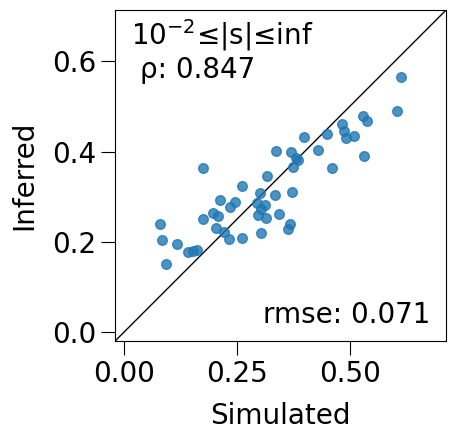

In [46]:
from validate import plot_all_gamma_results
plot_all_gamma_results(model, test_in, test_out, '../results/plots/afs')

In [2]:
# load training data
train_in = pickle.load(open('../data/processed_data/const_demog/train/tensors', 'rb'))
train_out = pickle.load(open('../data/processed_data/const_demog/train/labels', 'rb'))


In [3]:
train_in.shape

(2423, 20, 300, 2)

In [ ]:
create_dfe_cnn_afs(input_shape: tuple, n_outputs: int)

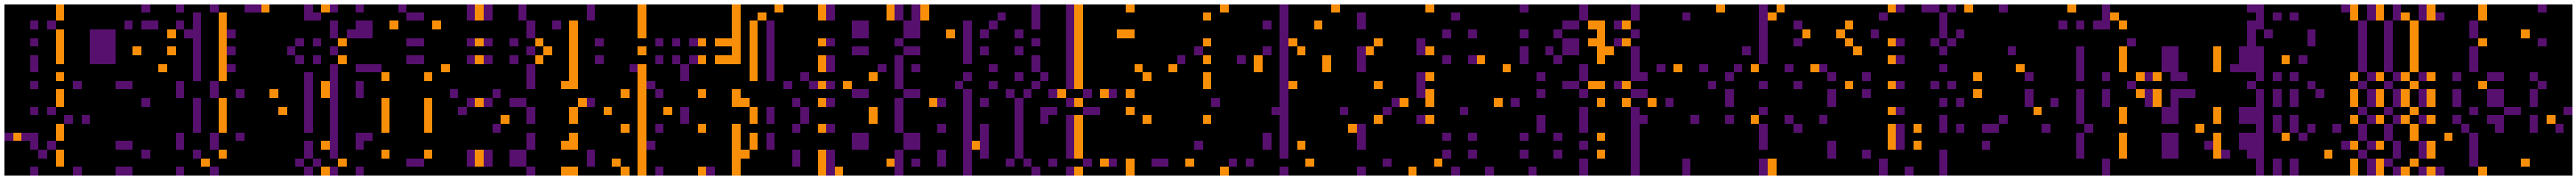

In [4]:
from process_data import visualize_snp_tensor

visualize_snp_tensor(train_in[0][:30])

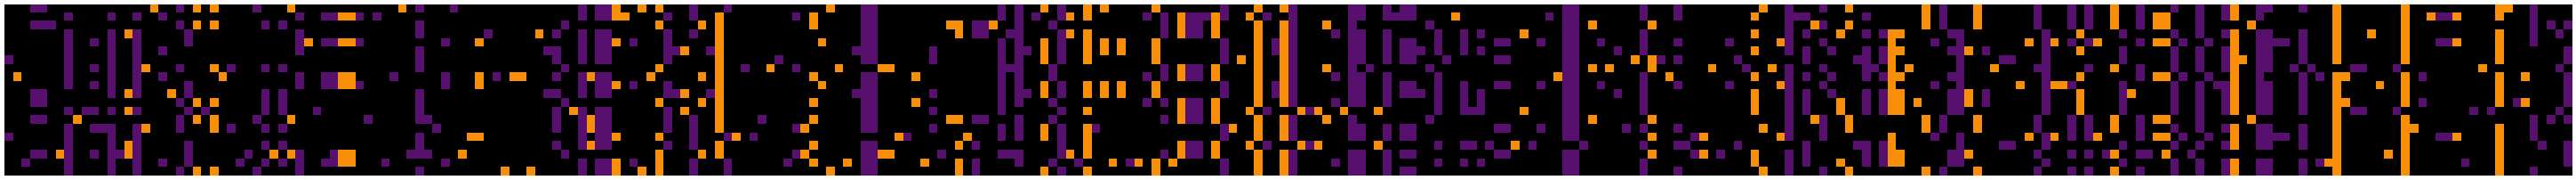

In [5]:
visualize_snp_tensor(train_in[1][:30])

In [9]:
def model_builder(hp):
    input_shape = (20, 300, 2)
    model = Sequential()
    model.add(
        layers.Conv1D(
            filters=64,
            kernel_size=5,
            strides=2,
            input_shape=input_shape,
            activation="relu",
        )
    )
    # A hyperparamter for whether to use dropout layer.
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(0.2))
    model.add(layers.Conv1D(filters=32, kernel_size=3, activation="relu"))
    model.add(layers.Conv1D(filters=16, kernel_size=2, strides=2, activation="relu"))
    model.add(layers.AveragePooling2D(pool_size=(20, 1)))
    model.add(layers.AveragePooling2D(pool_size=(1, 4)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(2, activation="relu"))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    # hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float(
        "learning_rate", min_value=1e-4, max_value=1e2, step=10, sampling="log"
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss="mse",
        metrics=["mean_squared_error"],
    )

    return model

In [22]:
print(f"The hyperparameter search is complete.\
    The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.\
        Dropout: {best_hps.get('dropout')}")

The hyperparameter search is complete.    The optimal learning rate for the optimizer is 0.001.        Dropout: True


In [10]:
# instantiate the Hyperband tuner
tuner = kt.Hyperband(model_builder,
                objective='val_loss',
                max_epochs=20)

# Create a callback to stop training early after reaching a certain value for the val_loss
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Run the hyperparameter search
tuner.search(train_in, train_out, epochs=30, validation_split=0.3, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The hyperparameter search is complete.\
    The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.\
        Dropout: {best_hps.get('dropout')}")


# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_in, train_out, epochs=30, validation_split=0.3)

# Find the optimal number of epochs to train the model
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(max(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

# Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
hypermodel = tuner.hypermodel.build(best_hps)
# Retrain the model
hypermodel.fit(train_in, train_out, epochs=best_epoch, validation_split=0.3)

# )

Trial 18 Complete [00h 00m 04s]
val_loss: 6.08924674987793

Best val_loss So Far: 0.628040075302124
Total elapsed time: 00h 01m 11s
INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete.
Epoch 1/30
53/53 [==============================] - 2s 11ms/step - loss: 2.4572 - mean_squared_error: 2.4572 - val_loss: 0.6972 - val_mean_squared_error: 0.6972
Epoch 2/30
53/53 [==============================] - 0s 9ms/step - loss: 0.5436 - mean_squared_error: 0.5436 - val_loss: 0.6626 - val_mean_squared_error: 0.6626
Epoch 3/30
53/53 [==============================] - 0s 9ms/step - loss: 0.5101 - mean_squared_error: 0.5101 - val_loss: 0.6454 - val_mean_squared_error: 0.6454
Epoch 4/30
53/53 [==============================] - 0s 9ms/step - loss: 0.4926 - mean_squared_error: 0.4926 - val_loss: 0.6363 - val_mean_squared_error: 0.6363
Epoch 5/30
53/53 [==============================] - 0s 9ms/step - loss: 0.4836 - mean_squared_error: 0.4836 - val_loss: 0.6328 - val_mean_squared_erro

In [11]:
best_hps.get('learning_rate')

0.001

In [13]:
best_hps.get('dropout')

True

In [15]:
best_hps.get_config()

{'space': [{'class_name': 'Boolean',
   'config': {'name': 'dropout', 'default': False, 'conditions': []}},
  {'class_name': 'Float',
   'config': {'name': 'learning_rate',
    'default': 0.0001,
    'conditions': [],
    'min_value': 0.0001,
    'max_value': 100.0,
    'step': 10,
    'sampling': 'log'}}],
 'values': {'dropout': True,
  'learning_rate': 0.001,
  'tuner/epochs': 20,
  'tuner/initial_epoch': 7,
  'tuner/bracket': 2,
  'tuner/round': 2,
  'tuner/trial_id': '0013'}}

In [ ]:
# hypermodel.save('../results/const_demog_trained_300')

In [26]:
model = tf.keras.saving.load_model('../results/const_demog_trained_300')

In [8]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 20, 148, 64)       704       
                                                                 
 dropout_2 (Dropout)         (None, 20, 148, 64)       0         
                                                                 
 conv1d_7 (Conv1D)           (None, 20, 146, 32)       6176      
                                                                 
 conv1d_8 (Conv1D)           (None, 20, 73, 16)        1040      
                                                                 
 average_pooling2d_4 (Averag  (None, 1, 73, 16)        0         
 ePooling2D)                                                     
                                                                 
 average_pooling2d_5 (Averag  (None, 1, 18, 16)        0         
 ePooling2D)                                          

In [23]:
# reload tensor data only
test_in = pickle.load(open('../data/processed_data/const_demog/test/tensors','rb'))
test_out = pickle.load(open('../data/processed_data/const_demog/test/labels','rb'))

In [28]:
from validate import plot_all_gamma_results

8/8 [==============================] - 0s 31ms/step


/home/lntran/miniconda3/envs/dfe-cnn/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/mnt/c/Users/Linh/OneDrive/projects/dfe-cnn/modules/validate.py:133: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

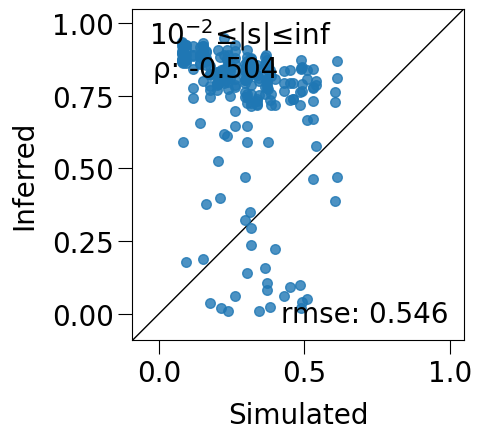

In [18]:
plot_all_gamma_results(hypermodel, test_in, test_out, '../results/plots/')

1/8 [==>...........................] - ETA: 0s

8/8 [==============================] - 0s 32ms/step


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

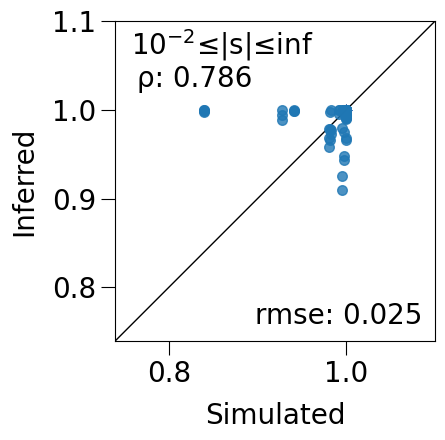

In [29]:
# plot_all_gamma_results(hypermodel, test_in, test_out, '../results/plots/')
plot_all_gamma_results(model, test_in, test_out, '../results/plots/')

In [ ]:
# another tuning version, with both MLP and CNN

def model_builder(hp):
    inputs = keras.Input(shape=(20, 300, 2))
    # Model type can be MLP or CNN.
    model_type = hp.Choice("model_type", ["mlp", "cnn"])
    x = inputs
    if model_type == "mlp":
        x = layers.Flatten()(x)
        # Number of layers of the MLP is a hyperparameter.
        for i in range(hp.Int("mlp_layers", 1, 3)):
            # Number of units of each layer are
            # different hyperparameters with different names.
            x = layers.Dense(
                units=hp.Int(f"units_{i}", 32, 128, step=32),
                activation="relu",
            )(x)

    else:
        # Number of layers of the CNN is also a hyperparameter.
        for i in range(hp.Int("cnn_layers", 1, 3)):
            x = layers.Conv1D(
                hp.Int(f"filters_{i}", 32, 128, step=32),
                kernel_size=hp.Int("kernel_size_{i}", min_value=2, max_value=10),
                strides=hp.Int("strides_{i}", min_value=1, max_value=3),
                activation="relu",
            )(x)
            # x = layers.MaxPooling2D(pool_size=(2, 2))(x)

        # for i in range(hp.Int("pooling_layers", 1, 3)):
        #     x = layers.AveragePooling2D(pool_size=(hp.Int(f"filters_{i}", 5, 20), 1))(x)

        x = layers.AveragePooling2D(pool_size=(20, 1))(x)
        x = layers.AveragePooling2D(pool_size=(1, 4))(x)
        x = layers.GlobalAveragePooling2D()(x)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float(
        "learning_rate", min_value=1e-4, max_value=1e2, step=10, sampling="log"
    )
        
    # A hyperparamter for whether to use dropout layer.
    if hp.Boolean("dropout"):
        x = layers.Dropout(0.2)(x)
        
    # final output layer
    outputs = layers.Dense(units=2, activation="relu")(x)
    
    # compile model
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss="mse",
        metrics=["mean_squared_error"],
    )

    return model

In [ ]:
# another tuning version, more extensive for CNN


def model_builder(hp):
    inputs = keras.Input(shape=(20, 300, 2))
    x = inputs
    # Number of layers of the CNN is also a hyperparameter.
    for i in range(hp.Int("cnn_layers", 1, 3)):
        x = layers.Conv1D(
            hp.Int(f"filters_{i}", 32, 128, step=32),
            kernel_size=hp.Int("kernel_size_{i}", min_value=2, max_value=10),
            strides=hp.Int("strides_{i}", min_value=1, max_value=3),
            activation="relu",
        )(x)

    # for i in range(hp.Int("pooling_layers", 2, 4)):
    #     x = layers.AveragePooling2D(
    #         pool_size=((hp.Int(f"pool_size_{i}", min_value=1, max_value=20),) * 2)
    #     )(x)

    x = layers.AveragePooling2D(pool_size=(20, 1))(x)
    x = layers.AveragePooling2D(pool_size=(1, 4))(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float(
        "learning_rate", min_value=1e-4, max_value=1e2, step=10, sampling="log"
    )

    # A hyperparamter for whether to use dropout layer.
    if hp.Boolean("dropout"):
        x = layers.Dropout(0.2)(x)

    # final output layer
    outputs = layers.Dense(units=2, activation="relu")(x)

    # compile model
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss="mse",
        metrics=["mean_squared_error"],
    )

    return model

In [ ]:
# We can do a quick test of the models to check if it build successfully for both CNN and MLP.
hp = kt.HyperParameters()
hp.values["model_type"] = "cnn"
# Build the model using the `HyperParameters`.
model = model_builder(hp)
# Test if the model runs with our data.
model(train_in[:10])
# Print a summary of the model.
model.summary()

# Do the same for MLP model.
hp.values["model_type"] = "mlp"
model = model_builder(hp)
model(train_in[:10])
model.summary()

In [ ]:
# instantiate the Hyperband tuner
tuner = kt.Hyperband(model_builder,
                objective='val_loss',
                max_epochs=10)

# Create a callback to stop training early after reaching a certain value for the val_loss
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Run the hyperparameter search
tuner.search(train_in, train_out, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print("The hyperparameter search is complete.")

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_in, train_out, epochs=50, validation_split=0.2)

# Find the optimal number of epochs to train the model
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(max(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

# Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
hypermodel = tuner.hypermodel.build(best_hps)
# Retrain the model
hypermodel.fit(train_in, train_out, epochs=best_epoch, validation_split=0.2)

In [ ]:
plot_all_gamma_results(hypermodel, test_in, test_out, '../results/plots/')